# Use Case 4: Comparing Mutation Protein Abundance

<b>Standard imports for playing with and plotting data frames.</b>

In [38]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

<b>Import CPTAC data</b>

In [3]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


In [4]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

### Test for protein levels (mutation in a gene with protein levels of any protein)

In [55]:
gene = 'TP53'
protList = ['TP53BP2']

pcutoff = 0.05/len(protList)
print(pcutoff)

genedf = somatic_mutations[gene].to_frame()
for protein in protList:
    if protein in proteomics.columns:
        proteindf = proteomics[protein].to_frame()
        cross = genedf.add(proteindf, fill_value=0).dropna(axis=0)
        mutated = cross.loc[cross[gene] == 1.0]
        wt = cross.loc[cross[gene] == 0.0]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        print("Test for " + protein + ": ")
        print(ttest)

0.05
Test for TP53BP2: 
Ttest_indResult(statistic=3.4447637901646937, pvalue=0.000842718770135264)


[Text(0,0.5,'Proteomics'), Text(0.5,0,'Somatic Gene Mutation')]

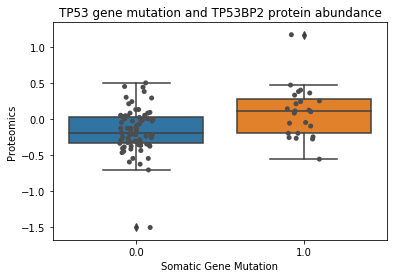

In [51]:
somatic_boxplot = sns.boxplot(data=cross, x="TP53",y="TP53BP2")
somatic_boxplot.set_title("TP53 gene mutation and TP53BP2 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="TP53", y="TP53BP2",jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")

### Test for phosphorylation levels (mutation in a gene with phosphorylation of any protein)

In [49]:
gene = 'TP53'
sites = phos.filter(regex='53BP2')

genedf = somatic_mutations[gene].to_frame()
cross = genedf.add(sites, fill_value=0)
mutated = cross.loc[cross[gene] == 1.0]
wt = cross.loc[cross[gene] == 0.0]

pcutoff = 0.05/len(cross.columns)
print(pcutoff)

for loc in cross.columns:
    if not loc == gene:
        mutsitedf = mutated[[gene, loc]].dropna()
        wtsitedf = wt[[gene, loc]].dropna()
        ttest = scipy.stats.ttest_ind(mutsitedf[loc], wtsitedf[loc])
        print('Results for ' + loc + ': ')
        print(ttest)

0.0038461538461538464
Results for TP53BP2-S367: 
Ttest_indResult(statistic=-0.17742167836523254, pvalue=0.8596969888925037)
Results for TP53BP2-S486: 
Ttest_indResult(statistic=0.725779192941792, pvalue=0.4705400086960684)
Results for TP53BP2-S487: 
Ttest_indResult(statistic=-1.0623734618846654, pvalue=0.2913443761600988)
Results for TP53BP2-S564: 
Ttest_indResult(statistic=-1.2580742436118233, pvalue=0.21185080408801113)
Results for TP53BP2-S575: 
Ttest_indResult(statistic=-1.3230154681923292, pvalue=0.18929704390894883)
Results for TP53BP2-S582: 
Ttest_indResult(statistic=1.9476816222042135, pvalue=0.05479334941482194)
Results for TP53BP2-S679: 
Ttest_indResult(statistic=1.5160752138796216, pvalue=0.1332546498505888)
Results for TP53BP2-S704: 
Ttest_indResult(statistic=1.126206248537993, pvalue=0.26381802089002687)
Results for TP53BP2-S720: 
Ttest_indResult(statistic=0.1577419697091523, pvalue=0.8750527005813037)
Results for TP53BP2-S743: 
Ttest_indResult(statistic=-1.559628504572745

### Test for phosphorylation levels and protein abundance

In [34]:
phosProt = phos.filter(regex='FGFR') 
protein = 'STAT1'

proteindf = proteomics[protein].to_frame()
cross = proteindf.add(phosProt, fill_value=0)

pcutoff = 0.05/len(cross.columns)
print(pcutoff)

for loc in cross.columns:
    if not loc == protein:
        oneSitedf = cross[[loc, protein]].dropna(axis=0)
        pearsonresult = pearsonr(oneSitedf[loc], oneSitedf[protein])
        print("Results for " + loc)
        print(pearsonresult)

0.01
Results for FGFR1OP-S152
(-0.03333259196372111, 0.7592285091138733)
Results for FGFR1OP-S156
(0.15158405081358645, 0.07486026784097914)
Results for FGFR1OP-S160
(0.22275628733958308, 0.008395276554038449)
Results for FGFR1OP-S279
(0.1048119063268295, 0.25458624353413445)


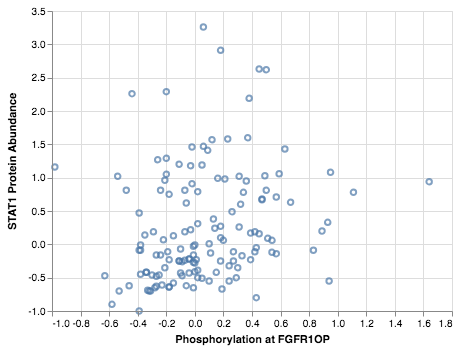

In [47]:
alt.Chart(cross).mark_point().encode(
    alt.X('FGFR1OP-S160', type='quantitative', axis=alt.Axis(title="Phosphorylation at FGFR1OP")),
    alt.Y('STAT1', type='quantitative', axis=alt.Axis(title="STAT1 Protein Abundance"))
)